## Exporting the modules 

In [3]:
using Printf
using Oceananigans
using Oceananigans.Utils
using Oceananigans.Units: minutes, hour, hours, day
using Oceananigans.Grids: nodes
using Oceananigans.Diagnostics
using Oceananigans.OutputWriters: JLD2OutputWriter, FieldSlicer, TimeInterval
using Oceananigans.Diagnostics: accurate_cell_advection_timescale

## Defining Grid

In [4]:
#number of grid spacing in south,north and vertical direction
const Nx=256
const Ny=256
const Nz=64

#Length of grid in south, north and vertical direction
const Lx=4
const Ly=4
const Lz=0.1

const S = 1.6 # Stretching factor
hyperbolically_spaced_nodes(k) = -Lz-Lz*(tanh(S * ( (-(k-Nz-1) ) / Nz - 1)) / tanh(S))
computational_grid = VerticallyStretchedRectilinearGrid(size = (Nx, Ny, Nz), 
                                                               architecture = CPU(),
                                                               x = (0,Lx),
                                                               y = (0,Ly),
                                                               halo = (3, 3, 3),
                                                               z_faces = hyperbolically_spaced_nodes)


VerticallyStretchedRectilinearGrid{Float64, Periodic, Periodic, Bounded}
                   domain: x ∈ [0.0, 4.0], y ∈ [0.0, 4.0], z ∈ [-0.1, 0.0]
                 topology: (Periodic, Periodic, Bounded)
  resolution (Nx, Ny, Nz): (256, 256, 64)
   halo size (Hx, Hy, Hz): (3, 3, 3)
grid spacing (Δx, Δy, Δz): (0.015625, 0.015625, [min=0.0004178411847718111, max=0.0027119068833282023])

## Governing parameters

In [5]:
#Coefficient of Thermal expansion
const alpha= 2e-4

#Coefficient of Salinity
const beta=0

#diffusive viscocity
const v=1e-5 
#diffusivity
const k=2e-6 

const f=-0.5   #coriolis parameter
 
g = 300

300

## Boundary conditions

### Temperature(Tracer) boundary condition

In [9]:
Amplitude = 950 # Amplitude (W/m²) of Heat flux

Q_cool = -143.1092 # (W/m²) {due to Longwave + Latent heat + Sensible Heat}

gausian(t) =  exp(-((t)^2)/(0.025*(86400)^2)) 

# These are the times during which peak of the heat flux can be observed
peak1 = 0.56day
peak2 = 1.56day
peak3 = 2.56day
peak4 = 3.56day
peak5 = 4.56day
peak6 = 5.56day

# Heat absorbed due to shortwave
Q_sh(t) = Amplitude*(gausian(t-peak1) + gausian(t-peak2) + gausian(t-peak3) + gausian(t-peak4)+ gausian(t-peak5)+ gausian(t-peak6) )


Q_sh (generic function with 1 method)

In [10]:
Q_net(t) = Q_sh(t) + Q_cool

Q_net (generic function with 1 method)

In [11]:
0.56day

48384.00000000001

In [12]:
function heatflux(t)
    if Q_net(t) <= 0
        bias = 1
        multiplier = 0
    else
        bias = 0
        multiplier = 1
    end
    
    return Q = bias*Q_cool
end

heatflux (generic function with 1 method)

In [13]:
t = 48384.00000000001
heatflux(t)

-0.0

In [14]:
dTdz = 0
T_bcs = FieldBoundaryConditions( top = FluxBoundaryCondition(heatflux(t)),
                                 bottom = GradientBoundaryCondition(dTdz))

Oceananigans.FieldBoundaryConditions, with boundary conditions
├── west: Oceananigans.BoundaryConditions.DefaultPrognosticFieldBoundaryCondition
├── east: Oceananigans.BoundaryConditions.DefaultPrognosticFieldBoundaryCondition
├── south: Oceananigans.BoundaryConditions.DefaultPrognosticFieldBoundaryCondition
├── north: Oceananigans.BoundaryConditions.DefaultPrognosticFieldBoundaryCondition
├── bottom: BoundaryCondition{Oceananigans.BoundaryConditions.Gradient, Int64}
├── top: BoundaryCondition{Oceananigans.BoundaryConditions.Flux, Float64}
└── immersed: BoundaryCondition{Oceananigans.BoundaryConditions.Flux, Nothing}

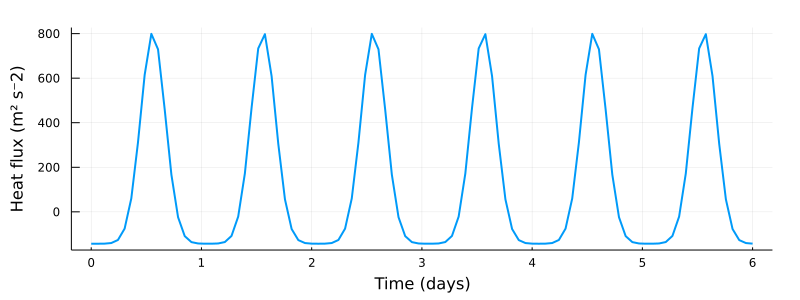

In [15]:
using Plots, Measures
time = range(0, 6day, length=100)

flux_plot = plot(time ./ day, [Q_net(t) for t in time],
                 linewidth = 2, xlabel = "Time (days)", ylabel = "Heat flux (m² s⁻2)",
                 size = (800, 300), margin = 5mm, label = nothing)

### Defining Heat Source Term as a forcing

In [16]:

function ShortWavePenetration(x,y,z,t)
    
    if Q_net(t) <= 0
        bias = 1
        multiplier = 0
    else
        bias = 0
        multiplier = 1
    end
    
    Q_band1(z) = (Ι/λ1)*exp(-z/λ1) 
    Q_band2(z) = (Ι/λ2)*exp(-z/λ2)
    
    if  z >= computational_grid.zᵃᵃᶜ[Nz]
        cooling_source = multiplier*Q_cool/(ρ*Cp*computational_grid.Δzᵃᵃᶜ[i])
        return Q_sh(t) * (Q_band1(z) + Q_band2(z))/(ρ*Cp) + (cooling_source*computational_grid.Δzᵃᵃᶜ[i])

    else 
        return Q_sh(t) * (Q_band1(z) + Q_band2(z))/(ρ*Cp)
    end

end

ShortWavePenetration_parameters = (ρ = 1000,
                                   Cp = 4182,
                                   λ1 = 0.35,
                                   λ2 = 23.0,
                                   Ι = 0.58
                                    )

(ρ = 1000, Cp = 4182, λ1 = 0.35, λ2 = 23.0, Ι = 0.58)

In [17]:
heat_source_term = Forcing(ShortWavePenetration,
                            parameters = ShortWavePenetration_parameters)

ContinuousForcing{NamedTuple{(:ρ, :Cp, :λ1, :λ2, :Ι), Tuple{Int64, Int64, Float64, Float64, Float64}}}
├── func: ShortWavePenetration
├── parameters: (ρ = 1000, Cp = 4182, λ1 = 0.35, λ2 = 23.0, Ι = 0.58)
└── field dependencies: ()

### Velocity Boundary conditions

In [18]:
const Qᵘ=0
u_bcs = FieldBoundaryConditions(top = FluxBoundaryCondition(Qᵘ), bottom=ValueBoundaryCondition(0.0))
v_bcs = FieldBoundaryConditions(top = FluxBoundaryCondition(Qᵘ), bottom=ValueBoundaryCondition(0.0))


Oceananigans.FieldBoundaryConditions, with boundary conditions
├── west: Oceananigans.BoundaryConditions.DefaultPrognosticFieldBoundaryCondition
├── east: Oceananigans.BoundaryConditions.DefaultPrognosticFieldBoundaryCondition
├── south: Oceananigans.BoundaryConditions.DefaultPrognosticFieldBoundaryCondition
├── north: Oceananigans.BoundaryConditions.DefaultPrognosticFieldBoundaryCondition
├── bottom: BoundaryCondition{Oceananigans.BoundaryConditions.Value, Float64}
├── top: BoundaryCondition{Oceananigans.BoundaryConditions.Flux, Int64}
└── immersed: BoundaryCondition{Oceananigans.BoundaryConditions.Flux, Nothing}

## Buoyancy that depends on temperature and salinity

We use the SeawaterBuoyancy model with a linear equation of state,

In [19]:
buoyancy = SeawaterBuoyancy(gravitational_acceleration = g,equation_of_state=LinearEquationOfState(α=alpha, β=beta))

SeawaterBuoyancy{Float64}: g = 300.0
└── equation of state: LinearEquationOfState{Float64}: α = 2.00e-04, β = 0.00e+00



## Model instantiation

In [20]:
using Oceananigans.Advection
using Oceananigans.TurbulenceClosures

model = NonhydrostaticModel(architecture = CPU(),
                            advection = UpwindBiasedFifthOrder(),
                            timestepper = :RungeKutta3,
                            grid = computational_grid,
                            tracers = (:T, :S),
                            coriolis = FPlane(f=f),
                            buoyancy = buoyancy,
                            closure = SmagorinskyLilly(),
                            forcing = (T=heat_source_term,),
                            boundary_conditions = (u=u_bcs, v=v_bcs, T=T_bcs))

NonhydrostaticModel{CPU, Float64}(time = 0 seconds, iteration = 0) 
├── grid: VerticallyStretchedRectilinearGrid{Float64, Periodic, Periodic, Bounded}(Nx=256, Ny=256, Nz=64)
├── tracers: (:T, :S)
├── closure: SmagorinskyLilly{Oceananigans.TurbulenceClosures.ExplicitTimeDiscretization, Float64, NamedTuple{(:T, :S), Tuple{Float64, Float64}}, NamedTuple{(:T, :S), Tuple{Float64, Float64}}}
├── buoyancy: SeawaterBuoyancy{Float64, LinearEquationOfState{Float64}, Nothing, Nothing}
└── coriolis: FPlane{Float64}

## Setting Initial Conditions

In [22]:
# Opening a file in read_mode
# r is the default mode
 
file = open("initial_condition.txt", "r")

IOStream(<file initial_condition.txt>)

In [24]:
s = read(file, String)  

"-0.00000000000000E+00 2.69073934063624E+01 3.62394511426444E+01\n-8.82817750175491E-02 2.69073934063624E+01 3.62394511426444E+01\n-1.77383410002193E-01 2.69073934063624E+01 3.62394511426444E+01\n-2.67312222483184E-01 2.69073934063624E+01 3.62394511426444E+01\n-3.58075589667436E-01 2.69073934063624E+01 3.62394511426444E+01\n-4.49680948817729E-01 2.69073934063624E+01 3.62394511426444E+01\n-5.42135797631346E-01 2.69072328331605E+01 3.62394458779821E+01\n-6.35447694618932E-01 2.69068685732966E+01 3.62394339351101E+01\n-7.29624259483074E-01 2.69065009380452E+01 3.62394218815704E+01\n-8.24673173497104E-01 2.69061298974212E+01 3.62394097163798E+01\n-9.20602179884213E-01 2.69057554211975E+01 3.62393974385474E+01\n-1.01741908419581E+00 2.69053774789036E+01 3.62393850470739E+01\n-1.11513175469028E+00 2.69049960398245E+01 3.62393725409525E+01\n-1.21374812271154E+00 2.69046110729986E+01 3.62393599191680E+01\n-1.31327618306676E+00 2.69042225472169E+01 3.62393471806972E+01\n-1.41372399440453E+00 2.